# Model Development

The purpose of this notebook is to use the previously downloaded and preprocessed Sentinel-2 image patch pairs and their corresponding cloud masks to build a conditional diffusion model. More specifically, the aim is to take a cloudy image as input and train a diffusion model to learn how to iteratively reconstruct a clear image, removing the clouds from the original cloudy input image. This notebook contains both the code to build/train the diffusion model and evaluate the results. 

# Set-Up

Install and import packages and set device for model training.

In [ ]:
# Install packages

#!pip install -r requirements.txt

In [8]:
# Import packages

from torch.utils.data import Dataset
import os
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [9]:
# Set device to CUDA if available, then MPS, then fall back to CPU

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Construct Data Classes

Construct classes to create dataset objects for training and testing. 

Image transformations:
 - Pixel clamping: [0,10000]
- Normalization

In [10]:
# Defnie dataset classes

class Sentinel2Normalize:
    def __call__(self, img):
        # img is assumed to be a torch Tensor in [0, ∞) after ToTensor()
        img = torch.clamp(img, 0, 10000)       # clip reflectance
        img = img / 10000.0                    # scale to [0, 1]
        img = img * 2 - 1                      # scale to [-1, 1]
        return img

class CloudRemovalDataset(Dataset):
    def __init__(self, cloudy_dir, clear_dir, mask_dir, image_size=256):
        self.cloudy_dir = cloudy_dir
        self.clear_dir = clear_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

        self.filenames = sorted(os.listdir(cloudy_dir))  # assume same names across all dirs
        self.filenames = self.filenames # limit for debugging

        self.image_transform = T.Compose([
            T.ToTensor(),                   
            T.Resize((image_size, image_size)),
            Sentinel2Normalize()             # custom normalization
        ])

        self.mask_transform = T.Compose([
            T.ToTensor(),              # shape becomes (1, H, W)
            T.Resize((image_size, image_size)),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        cloudy_path = os.path.join(self.cloudy_dir, fname)
        clear_path = os.path.join(self.clear_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

        # Load arrays
        cloudy_np = np.load(cloudy_path)
        clear_np = np.load(clear_path)
        mask_np = np.load(mask_path)  # shape (H, W), binary values

        # Convert to float32
        cloudy_np = cloudy_np.astype(np.float32)
        clear_np = clear_np.astype(np.float32) 

        # Convert to tensors and normalize
        cloudy = self.image_transform(cloudy_np)
        clear = self.image_transform(clear_np)
        mask = self.mask_transform(mask_np)  # shape (1, H, W), float32

        return {
            "cloudy": cloudy,    # (4, H, W)
            "clear": clear,      # (4, H, W)
            "mask": mask         # (1, H, W), binary float tensor
        }


# Construct Model Classes

Construct the classes to create the conditional diffusion model. See below for model details:

- Model Name: ConditionalUNet
- Inputs:
    - x: Noisy image tensor, shape [B, in_channels, H, W]
    - cond: Conditioning image tensor, shape [B, cond_channels, H, W]
    - t: Timestep (diffusion step), shape [B]
- Timestep Embedding:
    - Sinusoidal embedding of t into a vector of size embed_dim
    - Injected into convolutional blocks via learned MLP
- Architecture:
    - InputConv: DoubleConv(in_channels + cond_channels → base_channels)
    - Down1: MaxPool2D → DoubleConv(base_channels → base_channels * 2)
    - Down2: MaxPool2D → DoubleConv(base_channels * 2 → base_channels * 4)
    - Bottleneck: DoubleConv(base_channels * 4 → base_channels * 4)
    - Up1: ConvTranspose2D + skip connection from Down2 → DoubleConv(base_channels * 4 → base_channels * 2)
    - Up2: ConvTranspose2D + skip connection from Down1 → DoubleConv(base_channels * 2 → base_channels)
    - OutputConv: Conv2D(base_channels → in_channels) (1×1 kernel)
    - DoubleConv Block:
        - Two Conv2D → GroupNorm → GELU layers
        - Adds time embedding as a spatial bias
- Scheduler:
    - DiffusionScheduler handles forward diffusion (adds noise to input x based on timestep t)
    - Beta schedule: linear from 1e-4 to 0.02 over 1000 timesteps
- Default Hyperparameters:
    - in_channels=4, cond_channels=4
    - base_channels=64
    - embed_dim=256

In [11]:
# Define the model classes

def timestep_embedding(timesteps, dim):
    # sinusoidal embedding
    device = timesteps.device
    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1, 0, 0))
    return emb

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.GELU(),
        )
        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )

    def forward(self, x, t):
        h = self.double_conv(x)
        t_emb = self.time_embed(t).view(t.shape[0], -1, 1, 1)
        return h + t_emb

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim)

    def forward(self, x, t):
        return self.conv(self.pool(x), t)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim)

    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([x2, x1], dim=1), t)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, cond_channels=4, base_channels=64, embed_dim=256):
        super().__init__()
        self.embed_dim = embed_dim
        self.input_conv = DoubleConv(in_channels + cond_channels, base_channels, embed_dim)
        self.down1 = Down(base_channels, base_channels * 2, embed_dim)
        self.down2 = Down(base_channels * 2, base_channels * 4, embed_dim)
        self.bottleneck = DoubleConv(256, 256, embed_dim)
        self.up1 = Up(base_channels * 4, base_channels * 2, embed_dim)
        self.up2 = Up(base_channels * 2, base_channels, embed_dim)
        self.output_conv = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, cond, t):
        t_emb = timestep_embedding(t, self.embed_dim)
        x = torch.cat([x, cond], dim=1)
        x1 = self.input_conv(x, t_emb)
        x2 = self.down1(x1, t_emb)
        x3 = self.down2(x2, t_emb)
        x3 = self.bottleneck(x3, t_emb)
        x = self.up1(x3, x2, t_emb)
        x = self.up2(x, x1, t_emb)
        return self.output_conv(x)
    
# Define scheduler 

class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device=device):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise



# Train Model

This section constructs the dataset and model classes and runs the full training loop. See below for training configuration details:

- Epochs: 5
- Batch Size: 8
- Learning Rate: 1e-4 (Adam optimizer)
- Timesteps: 1000 (for diffusion)
- Image Size: 256×256
- Loss Weighting: alpha = 0.8 (mask-weighted loss)
- Numerical Stability: epsilon = 1e-8
- Device: GPU/CPU based on device variable
- Loss function
    - Hybrid loss: Full MSE + Cloud-weighted MSE (via cloud mask)

In [ ]:
# Full training loop

# --- Config ---
config = {
    "epochs": 5,
    "batch_size": 8,
    "lr": 1e-4,
    "timesteps": 1000,
    "image_size": 256,
    "device": device,
    "alpha": 0.8,
    "epsilon": 1e-8
}

# --- Load data ---
dataset = CloudRemovalDataset(
    cloudy_dir="/cs/student/projects2/aisd/2024/tcannon/ai4eo/temp/cloudy_patches",
    clear_dir="/cs/student/projects2/aisd/2024/tcannon/ai4eo/temp/clear_patches",
    mask_dir="/cs/student/projects2/aisd/2024/tcannon/ai4eo/temp/mask_patches",
    image_size=config["image_size"]
)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# --- Init model ---
model = ConditionalUNet().to(config["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = DiffusionScheduler(timesteps=config["timesteps"], device=config["device"])

# --- Denoising function ---
def p_sample_loop(model, scheduler, shape, cond, device):
    x = torch.randn(shape).to(device)
    for t in reversed(range(scheduler.timesteps)):
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)
        noise_pred = model(x, cond, t_batch)

        beta_t = scheduler.betas[t]
        alpha_t = scheduler.alphas[t]
        alpha_cumprod_t = scheduler.alpha_cumprod[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * noise_pred) + torch.sqrt(beta_t) * noise
    return x

# --- Training loop ---
train_losses = []
test_losses = []
psnr_scores = []
ssim_scores = []

for epoch in range(config["epochs"]):
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        cloudy = batch["cloudy"].to(config["device"])
        clear = batch["clear"].to(config["device"])
        mask = batch["mask"].to(config["device"])

        t = torch.randint(0, config["timesteps"], (cloudy.size(0),), device=config["device"]).long()
        noise = torch.randn_like(clear)
        noisy_clear = scheduler.q_sample(clear, t, noise)
        pred_noise = model(noisy_clear, cloudy, t)
        #loss = F.mse_loss(pred_noise, noise)

        # Expand mask to match channels
        if mask.shape[1] == 1 and pred_noise.shape[1] > 1:
            mask = mask.repeat(1, pred_noise.shape[1], 1, 1)

        squared_error = (pred_noise - noise) ** 2

        # Masked MSE loss over cloud-covered regions
        masked_loss = (mask * squared_error).sum() / (mask.sum() + config["epsilon"])

        # Full MSE loss over entire image
        full_loss = squared_error.mean()

        # Hybrid loss
        loss = config["alpha"] * masked_loss + (1 - config["alpha"]) * full_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            cloudy = batch["cloudy"].to(config["device"])
            clear = batch["clear"].to(config["device"])
            mask = batch["mask"].to(config["device"])

            t = torch.randint(0, config["timesteps"], (cloudy.size(0),), device=config["device"]).long()
            noise = torch.randn_like(clear)
            noisy_clear = scheduler.q_sample(clear, t, noise)
            pred_noise = model(noisy_clear, cloudy, t)

            if mask.shape[1] == 1 and pred_noise.shape[1] > 1:
                mask = mask.repeat(1, pred_noise.shape[1], 1, 1)

            squared_error = (pred_noise - noise) ** 2
            masked_loss = (mask * squared_error).sum() / (mask.sum() + config["epsilon"])
            full_loss = squared_error.mean()
            test_loss = config["alpha"] * masked_loss + (1 - config["alpha"]) * full_loss

            running_test_loss += test_loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss (MSE): {avg_train_loss:.4f}, Test Loss (MSE): {avg_test_loss:.4f}")


Train Epoch 1: 100%|██████████| 4237/4237 [1:37:55<00:00,  1.39s/it]  


[Epoch 1] Train Loss (MSE): 0.0471, Test Loss (MSE): 0.0179


Train Epoch 2: 100%|██████████| 4237/4237 [1:03:28<00:00,  1.11it/s]


[Epoch 2] Train Loss (MSE): 0.0185, Test Loss (MSE): 0.0157


Train Epoch 3: 100%|██████████| 4237/4237 [1:03:10<00:00,  1.12it/s]


[Epoch 3] Train Loss (MSE): 0.0152, Test Loss (MSE): 0.0133


Train Epoch 4: 100%|██████████| 4237/4237 [1:04:45<00:00,  1.09it/s]


[Epoch 4] Train Loss (MSE): 0.0133, Test Loss (MSE): 0.0136


Train Epoch 5: 100%|██████████| 4237/4237 [1:05:21<00:00,  1.08it/s]


[Epoch 5] Train Loss (MSE): 0.0129, Test Loss (MSE): 0.0113


In [6]:
# Save full trained model (contains model and optimizer state)

checkpoint_path = f"full_diffusion_model_epoch{epoch+1}.pt"
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': avg_train_loss,
    'test_loss': avg_test_loss
}, checkpoint_path)
print(f"Model saved to {checkpoint_path}")

Model saved to full_diffusion_model_epoch5.pt


In [7]:
# Save only model weights (lightweight)

model_weights_path = "full_diffusion_model_weights.pt"
torch.save(model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

Model weights saved to full_diffusion_model_weights.pt


# Model Evaluation

In this section I evaluate three trained models: one trained using 10,000 image patches, another trained using 20,000 image patches, and the final model trained using 37661 image patches (the full dataset). The goal of this was to evaluate the impact of additional training images and see how performance changes/improves as more training data is added. Furthermore, training time increases exponentially with additional images (7+ hours to train on the full dataset), so training on reduced images allowed more flexibility for debugging.

Models are evaluated using training/testing loss curves, visual inspection of generated samples, and structure accuracy metrics calculated on generated samples (PSNR and SSIM).

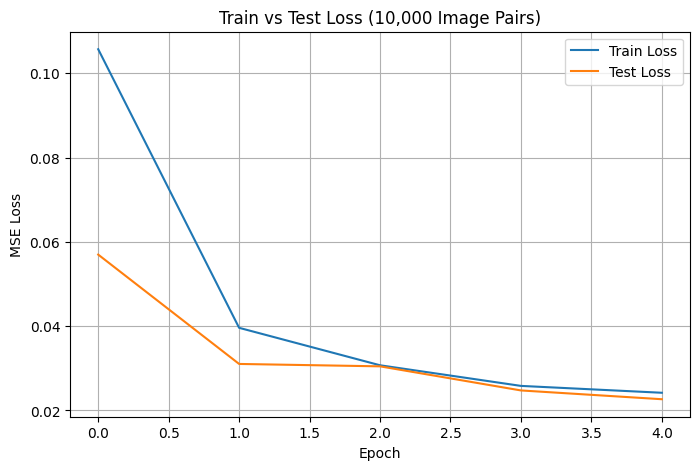

In [16]:
# Loss curve for model trained on limited dataset (10000 patches)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss (10,000 Image Pairs)")
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
plt.show()


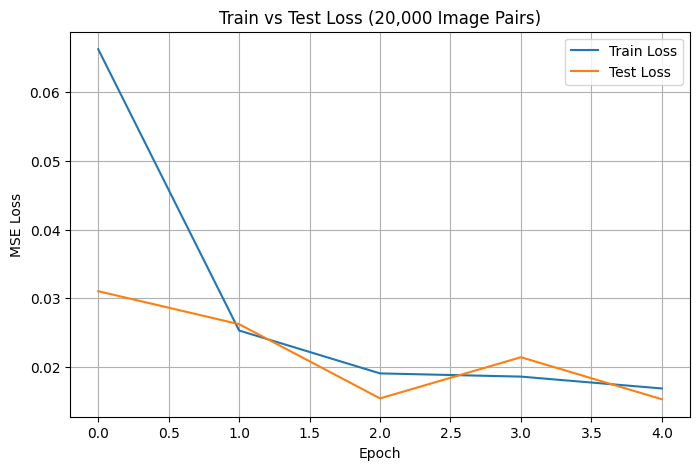

In [26]:
# Loss curve for model trained on limited dataset (20000 patches)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss (20,000 Image Pairs)")
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
plt.show()


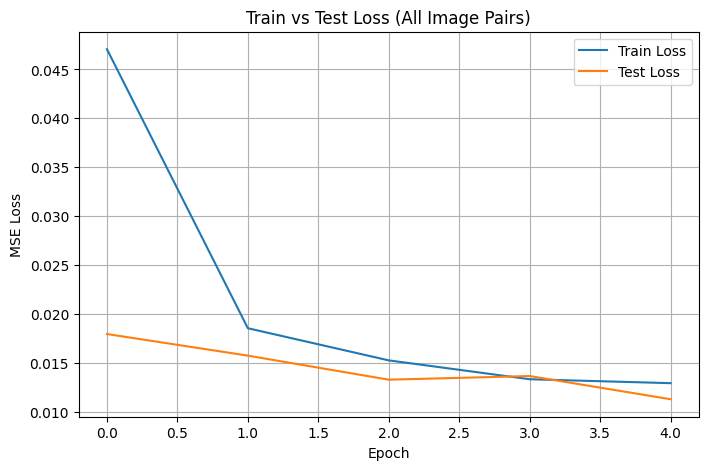

In [ ]:
# Loss curve for model trained on limited dataset (~38000 patches)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss (All Image Pairs)")
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
plt.show()

Image 1 - PSNR: 10.17, SSIM: 0.1426
Image 2 - PSNR: 6.33, SSIM: 0.3095
Image 3 - PSNR: 12.23, SSIM: 0.2437
Image 4 - PSNR: 9.16, SSIM: 0.2426

Average PSNR: 9.47
Average SSIM: 0.2346


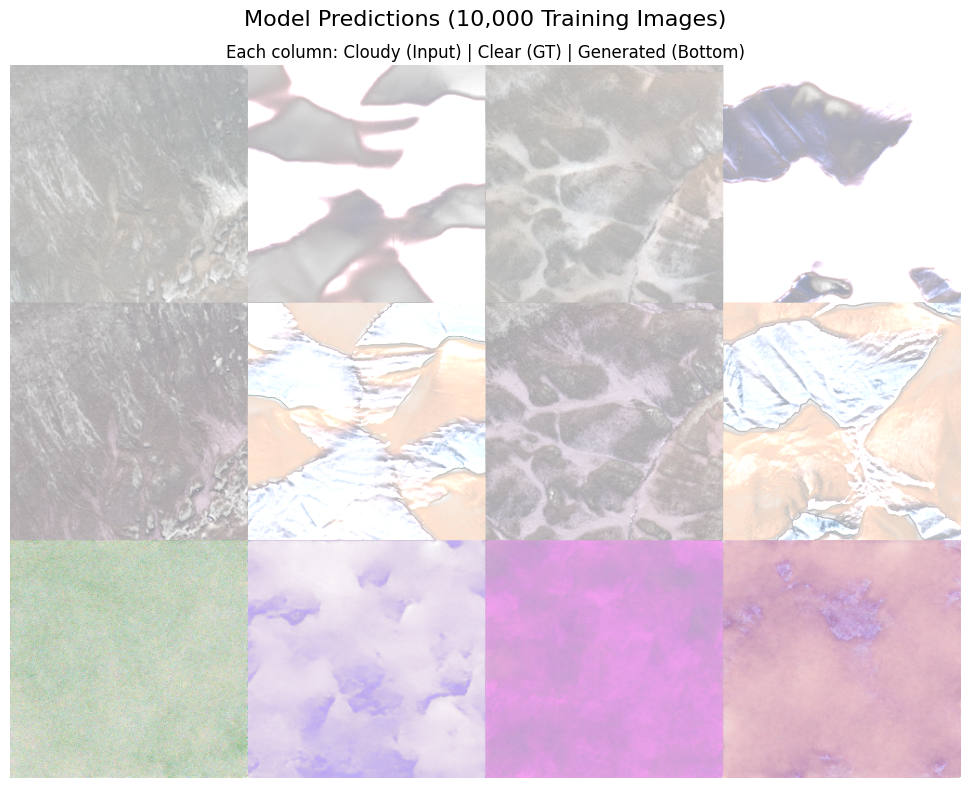

In [ ]:
# Sample and visualize model predictions: 10k model

def rescale_batch_channelwise(x):
    # x is (B, C, H, W)
    B, C, H, W = x.shape
    x_reshaped = x.view(B, C, -1)
    vmin = x_reshaped.min(dim=2, keepdim=True).values
    vmax = x_reshaped.max(dim=2, keepdim=True).values
    x_scaled = (x_reshaped - vmin) / (vmax - vmin + 1e-8)
    return x_scaled.view(B, C, H, W)

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    cloudy = batch["cloudy"].to(config["device"])  # the condition
    clear = batch["clear"].to(config["device"])    # ground truth

    # Generate image from noise, conditioned on the cloudy input
    generated = p_sample_loop(model, scheduler, shape=clear.shape, cond=cloudy, device=config["device"])

    # Rescale for visualization and metric computation
    cloudy_vis = rescale_batch_channelwise(cloudy[:4].cpu())
    clear_vis = rescale_batch_channelwise(clear[:4].cpu())
    gen_vis = rescale_batch_channelwise(generated[:4].cpu())

    # Compute PSNR & SSIM for the first 4 samples
    psnr_list = []
    ssim_list = []

    for i in range(4):
        gt = np.transpose(clear_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]
        pred = np.transpose(gen_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]

        psnr_val = peak_signal_noise_ratio(gt, pred, data_range=1.0)
        ssim_val = structural_similarity(gt, pred, data_range=1.0, channel_axis=-1)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

        print(f"Image {i+1} - PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    print(f"\nAverage PSNR: {np.mean(psnr_list):.2f}")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")

    # Stack each triplet vertically (along height = dim=1), then combine batch horizontally
    vis_list = []
    for i in range(4):
        stacked = torch.cat([cloudy_vis[i], clear_vis[i], gen_vis[i]], dim=1)  # stack vertically
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)  # concat horizontally

    # Plot
    plt.figure(figsize=(16, 8))
    plt.imshow(final_grid.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
    plt.title("Each column: Cloudy (Input) | Clear (GT) | Generated (Bottom)")
    plt.suptitle("Model Predictions (10,000 Training Images)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


Image 1 - PSNR: 10.65, SSIM: 0.2200
Image 2 - PSNR: 12.65, SSIM: 0.4265
Image 3 - PSNR: 11.67, SSIM: 0.2833
Image 4 - PSNR: 6.53, SSIM: 0.1794

Average PSNR: 10.38
Average SSIM: 0.2773


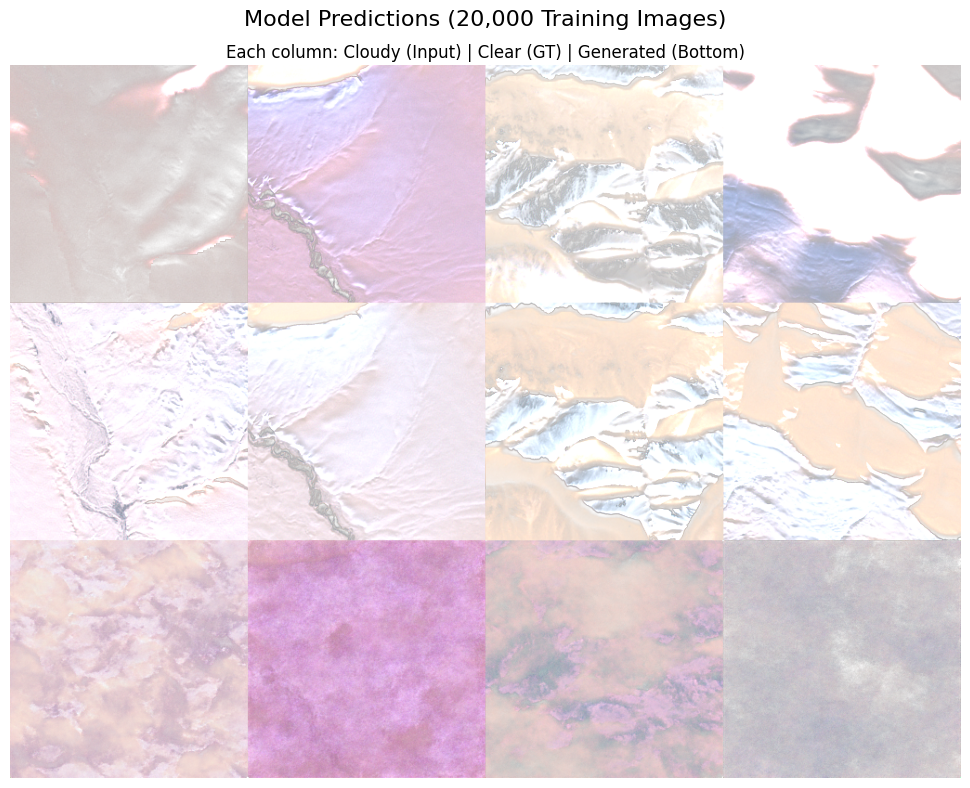

In [ ]:
# Sample and visualize model predictions: 20k model

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    cloudy = batch["cloudy"].to(config["device"])  # the condition
    clear = batch["clear"].to(config["device"])    # ground truth

    # Generate image from noise, conditioned on the cloudy input
    generated = p_sample_loop(model, scheduler, shape=clear.shape, cond=cloudy, device=config["device"])

    # Rescale for visualization and metric computation
    cloudy_vis = rescale_batch_channelwise(cloudy[:4].cpu())
    clear_vis = rescale_batch_channelwise(clear[:4].cpu())
    gen_vis = rescale_batch_channelwise(generated[:4].cpu())

    # Compute PSNR & SSIM for the first 4 samples
    psnr_list = []
    ssim_list = []

    for i in range(4):
        gt = np.transpose(clear_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]
        pred = np.transpose(gen_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]

        psnr_val = peak_signal_noise_ratio(gt, pred, data_range=1.0)
        ssim_val = structural_similarity(gt, pred, data_range=1.0, channel_axis=-1)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

        print(f"Image {i+1} - PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    print(f"\nAverage PSNR: {np.mean(psnr_list):.2f}")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")

    # Stack each triplet vertically (along height = dim=1), then combine batch horizontally
    vis_list = []
    for i in range(4):
        stacked = torch.cat([cloudy_vis[i], clear_vis[i], gen_vis[i]], dim=1)  # stack vertically
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)  # concat horizontally

    # Plot
    plt.figure(figsize=(16, 8))
    plt.imshow(final_grid.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
    plt.title("Each column: Cloudy (Input) | Clear (GT) | Generated (Bottom)")
    plt.suptitle("Model Predictions (20,000 Training Images)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Image 1 - PSNR: 13.23, SSIM: 0.2868
Image 2 - PSNR: 5.77, SSIM: 0.1261
Image 3 - PSNR: 8.45, SSIM: 0.2196
Image 4 - PSNR: 10.47, SSIM: 0.0779

Average PSNR: 9.48
Average SSIM: 0.1776


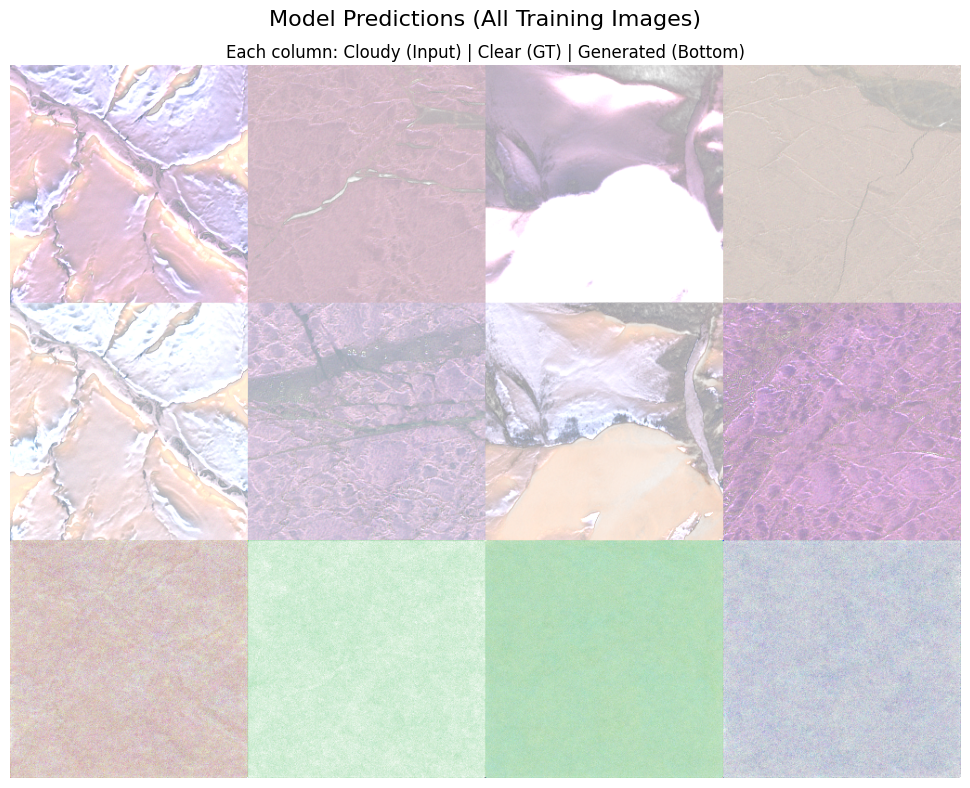

In [ ]:
# Sample and visualize model predictions: full (38k) model

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    cloudy = batch["cloudy"].to(config["device"])  # the condition
    clear = batch["clear"].to(config["device"])    # ground truth

    # Generate image from noise, conditioned on the cloudy input
    generated = p_sample_loop(model, scheduler, shape=clear.shape, cond=cloudy, device=config["device"])

    # Rescale for visualization and metric computation
    cloudy_vis = rescale_batch_channelwise(cloudy[:4].cpu())
    clear_vis = rescale_batch_channelwise(clear[:4].cpu())
    gen_vis = rescale_batch_channelwise(generated[:4].cpu())

    # Compute PSNR & SSIM for the first 4 samples
    psnr_list = []
    ssim_list = []

    for i in range(4):
        gt = np.transpose(clear_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]
        pred = np.transpose(gen_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]

        psnr_val = peak_signal_noise_ratio(gt, pred, data_range=1.0)
        ssim_val = structural_similarity(gt, pred, data_range=1.0, channel_axis=-1)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

        print(f"Image {i+1} - PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    print(f"\nAverage PSNR: {np.mean(psnr_list):.2f}")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")

    # Stack each triplet vertically (along height = dim=1), then combine batch horizontally
    vis_list = []
    for i in range(4):
        stacked = torch.cat([cloudy_vis[i], clear_vis[i], gen_vis[i]], dim=1)  # stack vertically
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)  # concat horizontally

    # Plot
    plt.figure(figsize=(16, 8))
    plt.imshow(final_grid.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
    plt.title("Each column: Cloudy (Input) | Clear (GT) | Generated (Bottom)")
    plt.suptitle("Model Predictions (All Training Images)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0332954..3.3481984].


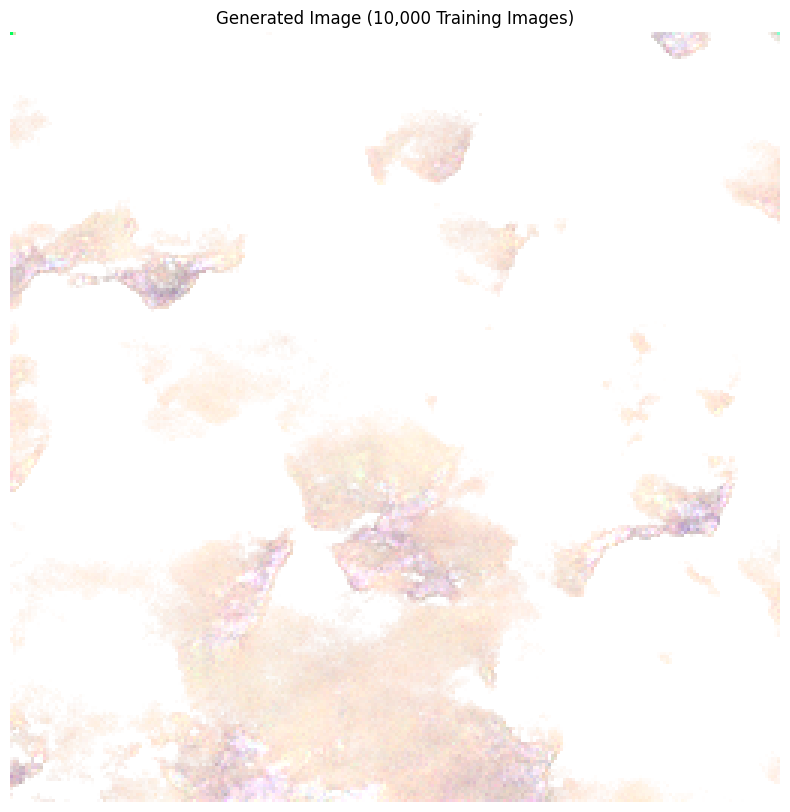

In [ ]:
# Plot unscaled generated image: 10k model

plt.figure(figsize=(8, 10))
plt.imshow(generated[1].permute(1, 2, 0).cpu().numpy())
plt.title("Generated Image (10,000 Training Images)")
plt.axis("off")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4577405..1.3226222].


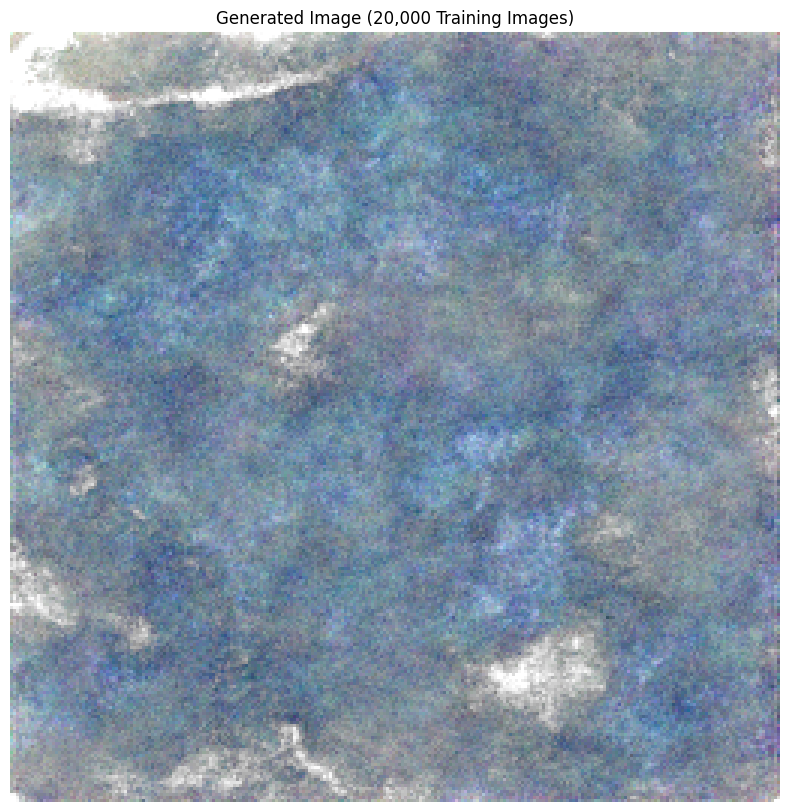

In [ ]:
# Plot unscaled generated image: 20k model

plt.figure(figsize=(8, 10))
plt.imshow(generated[1].permute(1, 2, 0).cpu().numpy())
plt.title("Generated Image (20,000 Training Images)")
plt.axis("off")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.33396..2.8560348].


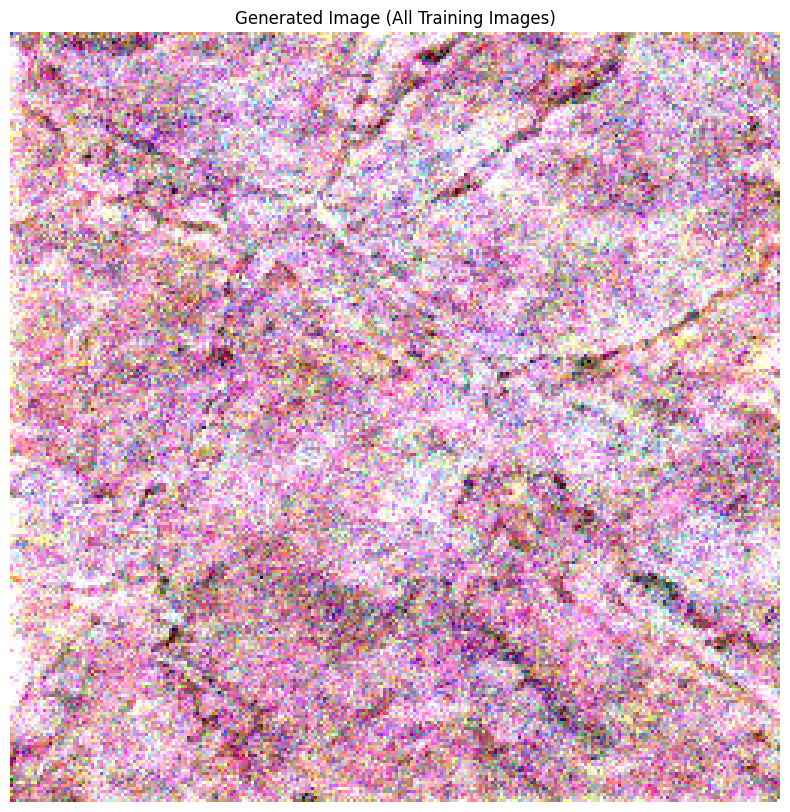

In [ ]:
# Plot unscaled generated image: full (38k) model

plt.figure(figsize=(8, 10))
plt.imshow(generated[0].permute(1, 2, 0).cpu().numpy())
plt.title("Generated Image #1 (All Training Images)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Controlled Model Evaluation 

In this section, I will compare the 10k, 20k, and full (38k) models on the same test images. This will allow for a direct, controlled comparison of the different models, indicating how performance changes with more training data. To do so, I will load in the saved trained models and run all three models on the test loader which was instantiated above for the full model training. 

In [ ]:
# Recreate the 10k model for inference

model_10k = ConditionalUNet().to(config['device']) # Use the same class and parameters
model_10k.load_state_dict(torch.load("/cs/student/projects2/aisd/2024/tcannon/ai4eo/10K_diffusion_model_weights.pt"))
model_10k.to(config["device"])

ConditionalUNet(
  (input_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
      (5): GELU(approximate='none')
    )
    (time_embed): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(1, 128, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(128, 128, kernel_size=(3, 3), stri

Image 1 - PSNR: 8.44, SSIM: 0.3084
Image 2 - PSNR: 9.98, SSIM: 0.2144
Image 3 - PSNR: 9.38, SSIM: 0.2895
Image 4 - PSNR: 10.12, SSIM: 0.1349

Average PSNR: 9.48
Average SSIM: 0.2368


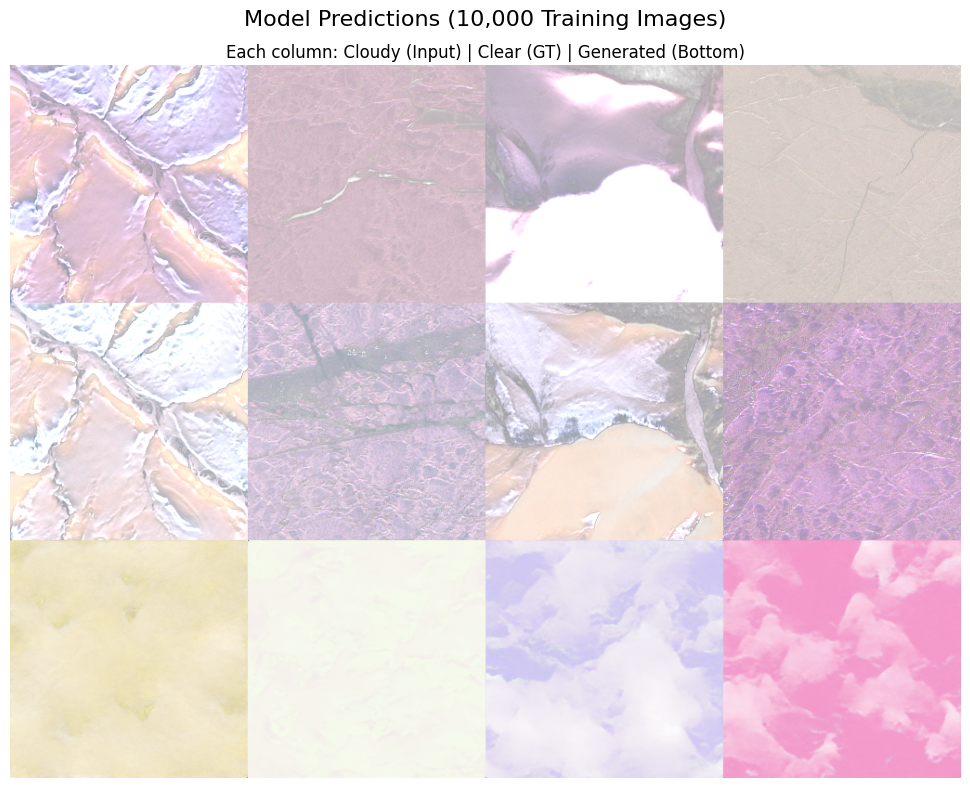

In [ ]:
# Sample and visualize model predictions: 10k model

model_10k.eval()

with torch.no_grad():
    batch = next(iter(test_loader))
    cloudy = batch["cloudy"].to(config["device"])  # the condition
    clear = batch["clear"].to(config["device"])    # ground truth

    # Generate image from noise, conditioned on the cloudy input
    generated = p_sample_loop(model_10k, scheduler, shape=clear.shape, cond=cloudy, device=config["device"])

    # Rescale for visualization and metric computation
    cloudy_vis = rescale_batch_channelwise(cloudy[:4].cpu())
    clear_vis = rescale_batch_channelwise(clear[:4].cpu())
    gen_vis = rescale_batch_channelwise(generated[:4].cpu())

    # Compute PSNR & SSIM for the first 4 samples
    psnr_list = []
    ssim_list = []

    for i in range(4):
        gt = np.transpose(clear_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]
        pred = np.transpose(gen_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]

        psnr_val = peak_signal_noise_ratio(gt, pred, data_range=1.0)
        ssim_val = structural_similarity(gt, pred, data_range=1.0, channel_axis=-1)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

        print(f"Image {i+1} - PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    print(f"\nAverage PSNR: {np.mean(psnr_list):.2f}")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")

    # Stack each triplet vertically (along height = dim=1), then combine batch horizontally
    vis_list = []
    for i in range(4):
        stacked = torch.cat([cloudy_vis[i], clear_vis[i], gen_vis[i]], dim=1)  # stack vertically
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)  # concat horizontally

    # Plot
    plt.figure(figsize=(16, 8))
    plt.imshow(final_grid.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
    plt.title("Each column: Cloudy (Input) | Clear (GT) | Generated (Bottom)")
    plt.suptitle("Model Predictions (10,000 Training Images)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# Recreate the 20k model for inference

model_20k = ConditionalUNet().to(config['device']) # Use the same class and parameters
model_20k.load_state_dict(torch.load("/cs/student/projects2/aisd/2024/tcannon/ai4eo/20K_diffusion_model_weights.pt"))
model_20k.to(config["device"])

ConditionalUNet(
  (input_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
      (5): GELU(approximate='none')
    )
    (time_embed): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(1, 128, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(128, 128, kernel_size=(3, 3), stri

Image 1 - PSNR: 11.31, SSIM: 0.3398
Image 2 - PSNR: 12.08, SSIM: 0.1762
Image 3 - PSNR: 8.59, SSIM: 0.2451
Image 4 - PSNR: 13.07, SSIM: 0.0938

Average PSNR: 11.26
Average SSIM: 0.2137


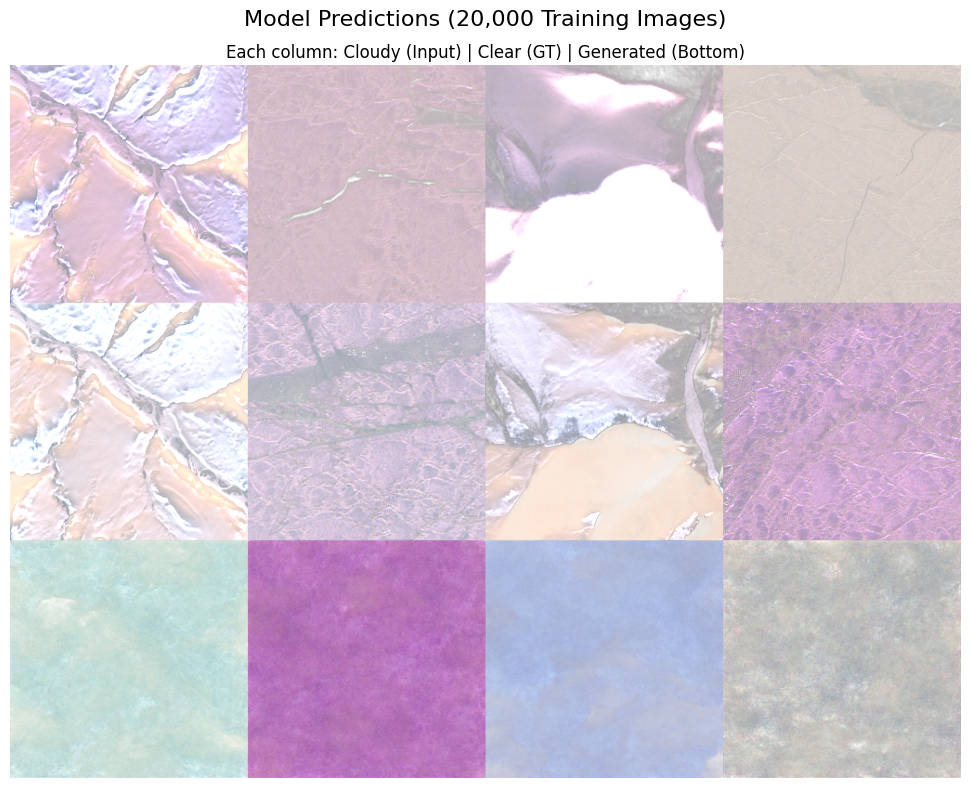

In [ ]:
# Sample and visualize model predictions: 20k model

model_20k.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    cloudy = batch["cloudy"].to(config["device"])  # the condition
    clear = batch["clear"].to(config["device"])    # ground truth

    # Generate image from noise, conditioned on the cloudy input
    generated = p_sample_loop(model_20k, scheduler, shape=clear.shape, cond=cloudy, device=config["device"])

    # Rescale for visualization and metric computation
    cloudy_vis = rescale_batch_channelwise(cloudy[:4].cpu())
    clear_vis = rescale_batch_channelwise(clear[:4].cpu())
    gen_vis = rescale_batch_channelwise(generated[:4].cpu())

    # Compute PSNR & SSIM for the first 4 samples
    psnr_list = []
    ssim_list = []

    for i in range(4):
        gt = np.transpose(clear_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]
        pred = np.transpose(gen_vis[i].numpy(), (1, 2, 0))   # [C, H, W] → [H, W, C]

        psnr_val = peak_signal_noise_ratio(gt, pred, data_range=1.0)
        ssim_val = structural_similarity(gt, pred, data_range=1.0, channel_axis=-1)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

        print(f"Image {i+1} - PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    print(f"\nAverage PSNR: {np.mean(psnr_list):.2f}")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")

    # Stack each triplet vertically (along height = dim=1), then combine batch horizontally
    vis_list = []
    for i in range(4):
        stacked = torch.cat([cloudy_vis[i], clear_vis[i], gen_vis[i]], dim=1)  # stack vertically
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)  # concat horizontally

    # Plot
    plt.figure(figsize=(16, 8))
    plt.imshow(final_grid.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
    plt.title("Each column: Cloudy (Input) | Clear (GT) | Generated (Bottom)")
    plt.suptitle("Model Predictions (20,000 Training Images)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

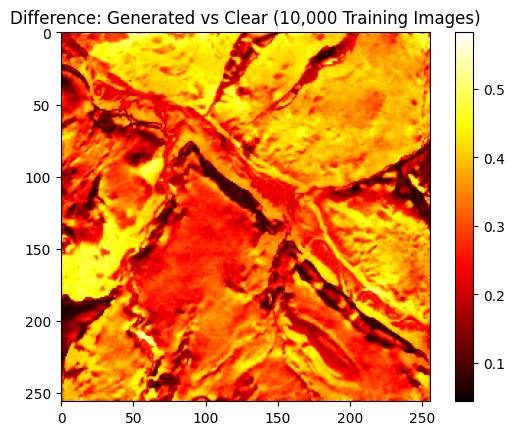

In [ ]:
# Plot the pixel-difference between a sample generated and clear image: 10k model 

diff = (gen_vis - clear_vis).abs().mean(dim=1, keepdim=True)  # per-pixel error map
plt.imshow(diff[0].cpu().squeeze(), cmap='hot')
plt.title("Difference: Generated vs Clear (10,000 Training Images)")
plt.colorbar()
plt.show()

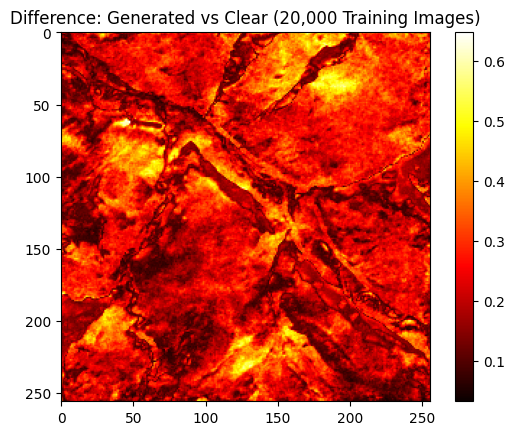

In [ ]:
# Plot the pixel-difference between a sample generated and clear image: 20k model 

diff = (gen_vis - clear_vis).abs().mean(dim=1, keepdim=True)  # per-pixel error map
plt.imshow(diff[0].cpu().squeeze(), cmap='hot')
plt.title("Difference: Generated vs Clear (20,000 Training Images)")
plt.colorbar()
plt.show()

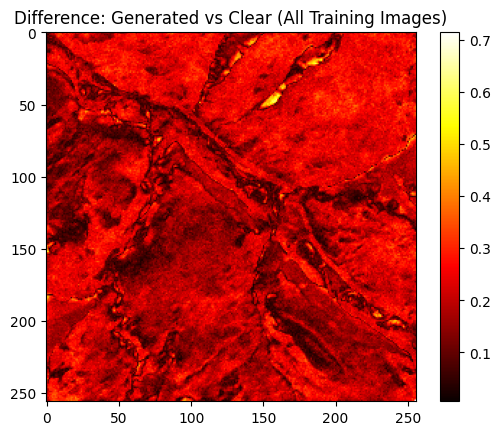

In [ ]:
# Plot the pixel-difference between a sample generated and clear image: full model 

diff = (gen_vis - clear_vis).abs().mean(dim=1, keepdim=True)  # per-pixel error map
plt.imshow(diff[0].cpu().squeeze(), cmap='hot')
plt.title("Difference: Generated vs Clear (All Training Images)")
plt.colorbar()
plt.show()